# Loading data fron Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Ensure the Kaggle directory exists and set the permissions without trying to recreate it
!mkdir -p ~/.kaggle  # The -p flag ensures that mkdir doesn't throw an error if the directory already exists
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d yuerugong/project1-zeta-surgical

100% 9.43G/9.44G [02:02<00:00, 126MB/s]
100% 9.44G/9.44G [02:02<00:00, 82.5MB/s]


In [ ]:
!unzip -q '/content/project1-zeta-surgical.zip' -d '/content/'

In [ ]:
!ls /content/renders/renders/multi/multi



brain_bone_window  brain_window  max_contrast_window  subdural_window


In [ ]:
!ls /content

 flagged.txt
 hemorrhage-labels.csv
 kaggle.json
 project1-zeta-surgical.zip
 renders
'Results_Brain Hemorrhage Tracing_2020-09-28_15.21.52.597.csv'
'Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv'
'Results_Intraparenchymal Hemorrhage Detection_2020-11-16_21.39.31.268.csv'
'Results_Multiple Hemorrhage Detection_2020-11-16_21.36.24.018.csv'
'Results_Subarachnoid Hemorrhage Detection_2020-11-16_21.36.18.668.csv'
'Results_Subdural Hemorrhage Detection_2020-11-16_21.35.48.040.csv'
'Results_Subdural Hemorrhage Detection_2020-11-16_21.37.19.745.csv'
 sample_data
'Segmentation Glossary (1).rtf'
'Segmentation Glossary.rtf'


In [ ]:
!find /content -name 'project1-zeta-surgical.zip'


/content/project1-zeta-surgical.zip


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
import tensorflow as tf
import keras
import seaborn as sns
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
#from sklearn.preprocessing import OneHotEncoder
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

In [ ]:
###################
## LOAD THE DATA ##
###################

hemmorrhage_labels_df = pd.read_csv('hemorrhage-labels.csv')
hemmorrhage_labels_df

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0
752799,ID_ffff922b9,1,0,0,1,0,0
752800,ID_ffffb670a,1,0,0,0,1,0
752801,ID_ffffcbff8,0,0,0,0,0,0


In [ ]:
# Flagged data
f = open("flagged.txt", "r")
flagged = [file.replace('\n','') for file in f.readlines()]
flagged += ['ID_6431af929.jpg']
flagged

['ID_20440abc6.jpg',
 'ID_1811d9bf2.jpg',
 'ID_75a698178.jpg',
 'ID_30010d605.jpg',
 'ID_34b04fff9.jpg',
 'ID_432bad415.jpg',
 'ID_3cb85bfca.jpg',
 'ID_4dad8b080.jpg',
 'ID_6431af929.jpg']

In [ ]:
# Segmented Epidural Data
epidural_results = pd.read_csv("Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv")
epidural_results = epidural_results[(epidural_results['Majority Label'].str.len() != 0) & (epidural_results['Correct Label'].notna())]
segmented_epidural_images = epidural_results['Origin'].values

epidural_dir = '/content/renders/renders/epidural/'
epidural_max_contrast = []
for dirname, _, filenames in os.walk(epidural_dir):
    for filename in filenames:
        if (filename in segmented_epidural_images) & (filename not in flagged):
            epidural_max_contrast.append(os.path.join(dirname, filename))
        if (len(epidural_max_contrast)==200):
            break
    else:
        continue
    break

epidural_data = []
epidural_label = []
for path in epidural_max_contrast:
    img = Image.open(path)
    img = img.resize((300,300))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (300,300,3)) & (len(label)==1)):
        epidural_data.append(np.array(img))
        epidural_label.append(label.values.flatten().tolist()[2:])

epidural_data = np.array(epidural_data)
print(epidural_data.shape)
epidural_label = np.array(epidural_label)
print(epidural_label.shape)

(200, 300, 300, 3)
(200, 5)


In [ ]:
# Segmented Intraparenchymal Data
intraparenchymal_results = pd.read_csv("Results_Intraparenchymal Hemorrhage Detection_2020-11-16_21.39.31.268.csv")
intraparenchymal_results = intraparenchymal_results[(intraparenchymal_results['Majority Label'].str.len() != 0) & (intraparenchymal_results['Correct Label'].notna())]
segmented_intraparenchymal_images = intraparenchymal_results['Origin'].values

intraparenchymal_dir = '/content/renders/renders/intraparenchymal/'

intraparenchymal_max_constrast = []
for dirname, _, filenames in os.walk(intraparenchymal_dir):
    for filename in filenames:
        if (filename in segmented_intraparenchymal_images) & (filename not in flagged):
            intraparenchymal_max_constrast.append(os.path.join(dirname, filename))
        if (len(intraparenchymal_max_constrast)==200):
            break
    else:
        continue
    break

intraparenchymal_data = []
intraparenchymal_label = []
for path in intraparenchymal_max_constrast:
    img = Image.open(path)
    img = img.resize((300,300))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (300,300,3)) & (len(label)==1)):
        intraparenchymal_data.append(np.array(img))
        intraparenchymal_label.append(label.values.flatten().tolist()[2:])

intraparenchymal_data = np.array(intraparenchymal_data)
print(intraparenchymal_data.shape)
intraparenchymal_label = np.array(intraparenchymal_label)
print(intraparenchymal_label.shape)

(200, 300, 300, 3)
(200, 5)


In [ ]:
# Segmented Subarachnoid Data
subarachnoid_results = pd.read_csv('Results_Subarachnoid Hemorrhage Detection_2020-11-16_21.36.18.668.csv')
subarachnoid_results = subarachnoid_results[(subarachnoid_results['Majority Label'].str.len() != 0) & (subarachnoid_results['Correct Label'].notna())]
segmented_subarachnoid_images = subarachnoid_results['Origin'].values
subarachnoid_dir = '/content/renders/renders/subarachnoid/'
subarachnoid_max_constrast = []
for dirname, _, filenames in os.walk(subarachnoid_dir):
    for filename in filenames:
        if (filename in segmented_subarachnoid_images) & (filename not in flagged):
            subarachnoid_max_constrast.append(os.path.join(dirname, filename))
        if (len(subarachnoid_max_constrast)==200):
            break
    else:
        continue
    break

subarachnoid_data = []
subarachnoid_label = []
for path in subarachnoid_max_constrast:
    img = Image.open(path)
    img = img.resize((300,300))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (300,300,3)) & (len(label)==1)):
        subarachnoid_data.append(np.array(img))
        subarachnoid_label.append(label.values.flatten().tolist()[2:])

subarachnoid_data = np.array(subarachnoid_data)
print(subarachnoid_data.shape)
subarachnoid_label = np.array(subarachnoid_label)
print(subarachnoid_label.shape)


(200, 300, 300, 3)
(200, 5)


In [ ]:
# Segmented Subdural Data
subdural_results = pd.read_csv("Results_Subdural Hemorrhage Detection_2020-11-16_21.35.48.040.csv")
subdural_results = subdural_results[(subdural_results['Majority Label'].str.len() != 0) & (subdural_results['Correct Label'].notna())]
segmented_subdural_images = subdural_results['Origin'].values
subdural_max_constrast = []
subdural_dir = '/content/renders/renders/subdural/'
for dirname, _, filenames in os.walk(subdural_dir):
    for filename in filenames:
        if (filename in segmented_subdural_images) & (filename not in flagged):
            subdural_max_constrast.append(os.path.join(dirname, filename))
        if (len(subdural_max_constrast)==200):
            break
    else:
        continue
    break

subdural_data = []
subdural_label = []
for path in subdural_max_constrast:
    img = Image.open(path)
    img = img.resize((300,300))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (300,300,3)) & (len(label)==1)):
        subdural_data.append(np.array(img))
        subdural_label.append(label.values.flatten().tolist()[2:])

subdural_data = np.array(subdural_data)
print(subdural_data.shape)
subdural_label = np.array(subdural_label)
print(subdural_label.shape)

(200, 300, 300, 3)
(200, 5)


In [ ]:
# Segmented Multiple Data
multiple_results = pd.read_csv("Results_Multiple Hemorrhage Detection_2020-11-16_21.36.24.018.csv")
multiple_results = multiple_results[(multiple_results['Majority Label'].str.len() != 0) & (multiple_results['Correct Label'].notna())]
segmented_multiple_images = multiple_results['Origin'].values
multiple_dir = '/content/renders/renders/multi/'
multiple_max_constrast = []
for dirname, _, filenames in os.walk(multiple_dir):
    for filename in filenames:
        if (filename in segmented_multiple_images) & (filename not in flagged):
            multiple_max_constrast.append(os.path.join(dirname, filename))
        if (len(multiple_max_constrast)==200):
            break
    else:
        continue
    break

multiple_data = []
multiple_label = []
for path in multiple_max_constrast:
    img = Image.open(path)
    img = img.resize((300,300))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (300,300,3)) & (len(label)==1)):
        multiple_data.append(np.array(img))
        multiple_label.append(label.values.flatten().tolist()[2:])

multiple_data = np.array(multiple_data)
print(multiple_data.shape)
multiple_label = np.array(multiple_label)
print(multiple_label.shape)

(200, 300, 300, 3)
(200, 5)


In [ ]:
# Intraventricular Data
intraventricular_dir = '/content/renders/renders/intraventricular/'
intraventricular_max_constrast = []
for dirname, _, filenames in os.walk(intraventricular_dir):
    for filename in filenames:
        if (filename not in flagged):
            intraventricular_max_constrast.append(os.path.join(dirname, filename))
        if (len(intraventricular_max_constrast)==200):
            break
    else:
        continue
    break


intraventricular_data = []
intraventricular_label = []
for path in intraventricular_max_constrast:
    img = Image.open(path)
    img = img.resize((300,300))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (300,300,3)) & (len(label)==1)):
        intraventricular_data.append(np.array(img))
        intraventricular_label.append(label.values.flatten().tolist()[2:])

intraventricular_data = np.array(intraventricular_data)
print(intraventricular_data.shape)
intraventricular_label = np.array(intraventricular_label)
print(intraventricular_label.shape)


(200, 300, 300, 3)
(200, 5)


In [ ]:
# Normal Data
normal_dir = '/content/renders/renders/normal/'
normal_max_constrast = []
for dirname, _, filenames in os.walk(normal_dir):
    for filename in filenames:
        if (filename not in flagged):
            normal_max_constrast.append(os.path.join(dirname, filename))
        if (len(normal_max_constrast)==200):
            break
    else:
        continue
    break


normal_data = []
normal_label = []
for path in normal_max_constrast:
    img = Image.open(path)
    img = img.resize((300,300))
    img = np.array(img)
    if((img.shape == (300,300,3)) & (len(label)==1)):
        normal_data.append(np.array(img))
        normal_label.append([0,0,0,0,0])

normal_data = np.array(normal_data)
print(normal_data.shape)
normal_label = np.array(normal_label)
print(normal_label.shape)


(200, 300, 300, 3)
(200, 5)


In [ ]:
# Combine all the data
all_data = np.vstack((epidural_data,intraparenchymal_data,subarachnoid_data,subdural_data,multiple_data,intraventricular_data,normal_data))
all_label = np.vstack((epidural_label,intraparenchymal_label,subarachnoid_label,subdural_label,multiple_label,intraventricular_label,normal_label))
print(all_data.shape)
print(all_label.shape)

(1400, 300, 300, 3)
(1400, 5)


In [ ]:
# Shuffle the data
shuffle_index = np.random.permutation(all_data.shape[0])
X_data = all_data[shuffle_index]
y_data = all_label[shuffle_index]

In [ ]:
# Split train, test, val
[X_train, X_rest, y_train, y_rest] = train_test_split(X_data, y_data, test_size = 0.2, random_state=0)
[X_val, X_test, y_val, y_test] = train_test_split(X_rest, y_rest, test_size=0.5, random_state=0)

In [ ]:
# Normalize the data
X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.

In [ ]:
## Add an extra dimension
X_train = X_train.reshape(-1, 300, 300, 3)
X_test = X_test.reshape(-1, 300, 300, 3)
X_val = X_val.reshape(-1, 300, 300, 3)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)


(1120, 300, 300, 3)
(1120, 5)
(140, 300, 300, 3)
(140, 5)
(140, 300, 300, 3)
(140, 5)


In [ ]:
#####################
## TRAIN THE MODEL ##
#####################

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define the model
model = keras.models.Sequential()

#model.add(InputLayer(input_shape=(300, 300, 3)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same', input_shape=(300,300,3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=5, activation='softmax'))


In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 25)      1900      
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 25)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 50)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 38, 38, 50)        200       
 Normalization)                                                  
                                                        

In [36]:
# Train the model
epochs = 30

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    #batch_size=300,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/30
35/35 [==============================] - 27s 734ms/step - loss: 2.0075 - accuracy: 0.1884 - val_loss: 1.6541 - val_accuracy: 0.2286
Epoch 2/30
35/35 [==============================] - 25s 721ms/step - loss: 1.9602 - accuracy: 0.2125 - val_loss: 1.6654 - val_accuracy: 0.2429
Epoch 3/30
35/35 [==============================] - 25s 719ms/step - loss: 3.3308 - accuracy: 0.2134 - val_loss: 1.6802 - val_accuracy: 0.2071
Epoch 4/30
35/35 [==============================] - 25s 717ms/step - loss: 6.4800 - accuracy: 0.2134 - val_loss: 2.1377 - val_accuracy: 0.1857
Epoch 5/30
35/35 [==============================] - 25s 720ms/step - loss: 18.4126 - accuracy: 0.2411 - val_loss: 5.9815 - val_accuracy: 0.2429
Epoch 6/30
35/35 [==============================] - 25s 721ms/step - loss: 52.6647 - accuracy: 0.2018 - val_loss: 19.0549 - val_accuracy: 0.3214
Epoch 7/30
35/35 [==============================] - 25s 727ms/step - loss: 87.5510 - accuracy: 0.2223 - val_loss: 96.5520 - val_accuracy: 0

KeyboardInterrupt: 

In [38]:
#############################
## TRAIN THE DEEP NN MODEL ##
#############################

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Define the model
dnn_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(300, 300, 3)),  # Flatten the input images
    keras.layers.Dense(512, activation='relu'),       # First hidden layer with 512 neurons and ReLU activation
    keras.layers.Dropout(0.3),                        # Dropout layer for regularization
    keras.layers.Dense(256, activation='relu'),       # Second hidden layer with 256 neurons and ReLU activation
    keras.layers.Dropout(0.3),                        # Another Dropout layer for regularization
    keras.layers.Dense(128, activation='relu'),       # Third hidden layer with 128 neurons and ReLU activation
    keras.layers.Dropout(0.3),                        # Additional Dropout layer
    keras.layers.Dense(5, activation='softmax')       # Output layer with 5 units for each class
])

# Compile the model
dnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Show the model summary
print(dnn_model.summary())

history_dnn = dnn_model.fit(X_train, y_train,
                            epochs=30,
                            batch_size=64,
                            verbose=1,
                            validation_data=(X_val, y_val))

#stochastic gradient decent
historysgd = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 512)               138240512 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

NameError: name 'history' is not defined

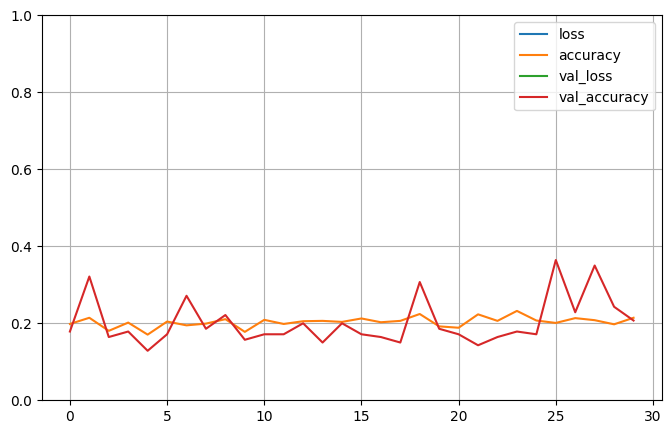

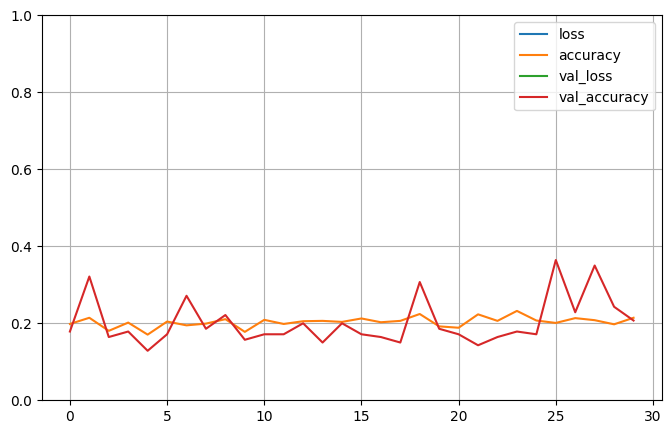

In [40]:
pd.DataFrame(historysgd.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()


pd.DataFrame(historysgd.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()